In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from string import punctuation
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
pd.set_option('max_columns', None)

In [56]:
input_dir = os.path.join('../input', 'nfl-big-data-bowl-2020')
train_path = os.path.join(input_dir, 'train.csv')
df = pd.read_csv(train_path)

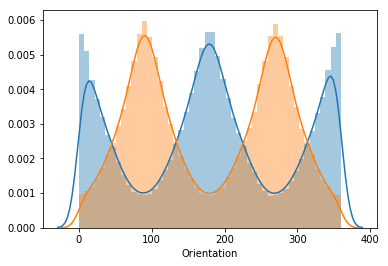

In [58]:
sns.distplot(df[df['Season']==2017]['Orientation'].fillna(0))
sns.distplot(df[df['Season']==2018]['Orientation'].fillna(0))

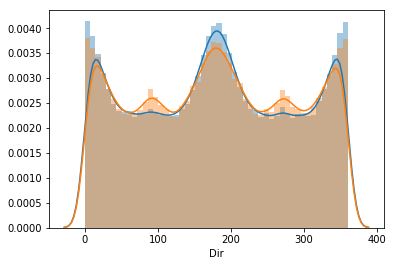

In [59]:
sns.distplot(df[df['Season']==2017]['Dir'].fillna(0))
sns.distplot(df[df['Season']==2018]['Dir'].fillna(0))

In [61]:
def new_orientation(angle, play_direction):
    if play_direction == 'left':
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle
df['Orientation_v1'] = df.apply(lambda row: new_orientation(row['Orientation'], row['PlayDirection']), axis=1)
df['Dir_v1'] = df.apply(lambda row: new_orientation(row['Dir'], row['PlayDirection']), axis=1)

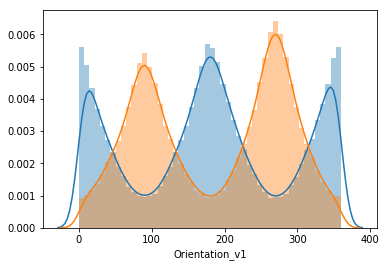

In [62]:
sns.distplot(df[df['Season']==2017]['Orientation_v1'].fillna(0))
sns.distplot(df[df['Season']==2018]['Orientation_v1'].fillna(0))

In [66]:
df['Orientation_v2'] = df['Orientation_v1']
df.loc[df['Season'] == 2017, 'Orientation_v2'] = np.mod(90 + df.loc[df['Season'] ==2017, 'Orientation_v2'], 360)

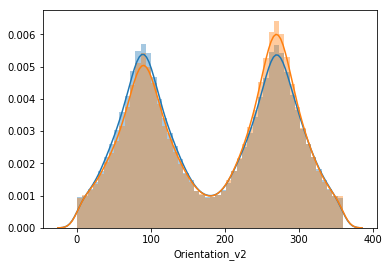

In [67]:
sns.distplot(df[df['Season']==2017]['Orientation_v2'].fillna(0))
sns.distplot(df[df['Season']==2018]['Orientation_v2'].fillna(0))


## Subtract Orientation and Dir

In [10]:
df.head(3)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,Orientation_v1,Dir_v1,Orientation_v2
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,278.01,182.82,8.01
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,332.39,161.30,62.39
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,356.99,157.27,86.99


             Ori_Dir_Sub     Yards
Ori_Dir_Sub     1.000000  0.010353
Yards           0.010353  1.000000


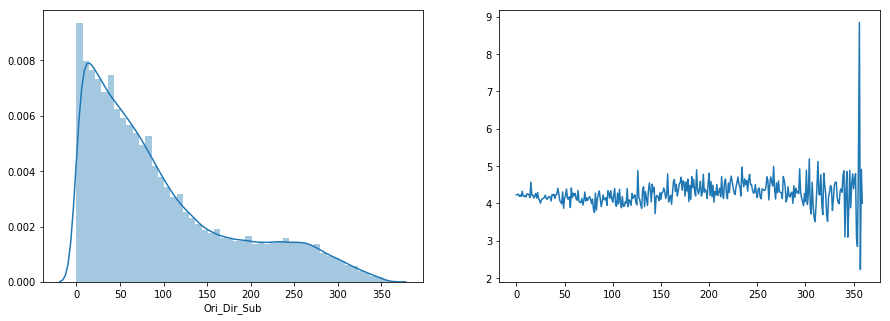

In [128]:
tmp = df.copy()
tmp['Ori_Dir_Sub'] =abs(tmp['Orientation_v2'] - tmp['Dir'])
tmp['Ori_Dir_Sub'] = tmp['Ori_Dir_Sub'].fillna(0).astype(np.int16)
print(tmp[['Ori_Dir_Sub', 'Yards']].corr())
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

sns.distplot(tmp['Ori_Dir_Sub'], ax=axes[0])

plt.plot(tmp[['Ori_Dir_Sub', 'Yards']].groupby(['Ori_Dir_Sub'])['Yards'].mean())
plt.show()

                 Sub_Ori_Dri_sub     Yards
Sub_Ori_Dri_sub         1.000000  0.043945
Yards                   0.043945  1.000000


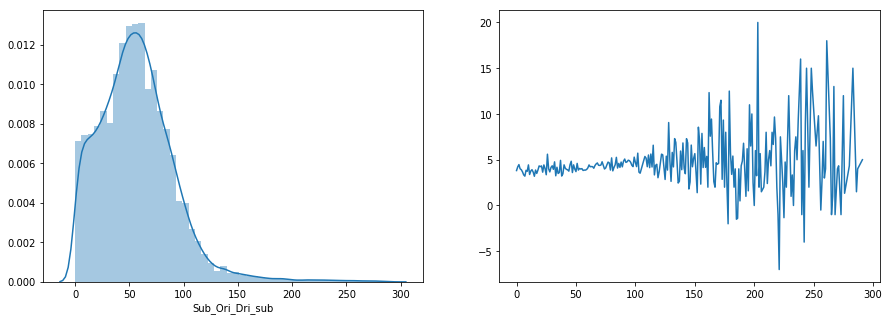

In [129]:
tmp_norusher = tmp[tmp['NflId'] != tmp['NflIdRusher']]
t_ori = tmp_norusher.groupby(['GameId', 'PlayId'])['Ori_Dir_Sub'].mean().reset_index()
t_ori.columns = ['GameId', 'PlayId', 'Sub_Ori_Dri_norusher']
tmp_rusher = tmp[tmp['NflId'] == tmp['NflIdRusher']]
#tmp_rusher['Sub_Ori_Dri_norusher'] = t_ori.values
tmp_rusher = pd.merge(tmp_rusher, t_ori, on=['GameId', 'PlayId'], how='inner')
tmp_rusher['Sub_Ori_Dri_sub'] = abs(tmp_rusher['Ori_Dir_Sub'] - tmp_rusher['Sub_Ori_Dri_norusher'])
tmp_rusher['Sub_Ori_Dri_sub'] = tmp_rusher['Sub_Ori_Dri_sub'].fillna(0).astype(np.int16)
print(tmp_rusher[['Sub_Ori_Dri_sub', 'Yards']].corr())
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

sns.distplot(tmp_rusher['Sub_Ori_Dri_sub'], ax=axes[0])

plt.plot(tmp_rusher[['Sub_Ori_Dri_sub', 'Yards']].groupby(['Sub_Ori_Dri_sub'])['Yards'].mean())
plt.show()

In [117]:
tmp_rusher.head(3)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,Orientation_v1,Dir_v1,Orientation_v2,Sub_Ori_Dri,Sub_Ori_Dri_norusher,Sub_Ori_Dri_sub
18,2017090700,20170907000118,home,78.75,30.53,3.63,3.35,0.38,161.98,245.74,2543773,James White,28,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,198.02,114.26,288.02,42,92.047619,50
40,2017090700,20170907000139,home,71.07,27.16,3.06,2.41,0.34,210.70,312.20,2543773,James White,28,2017,43,1,13:52:00,NE,1,10,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:27.000Z,2017-09-08T00:44:26.000Z,3,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,149.30,47.80,239.30,72,100.952381,28
62,2017090700,20170907000189,home,48.66,19.11,5.77,2.42,0.60,140.82,221.96,2543773,James White,28,2017,35,1,13:02:00,NE,1,10,KC,0,0,2543773,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:45:17.000Z,2017-09-08T00:45:15.000Z,5,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,219.18,138.04,309.18,87,102.809524,15
